# Compound-Protein Interaction

The process of developing drugs is extensive, laborious, expensive, and time consuming. Drug repurposing, also referred to as repositioning, significantly reduces the cost, risk, and time compared to traditional drug development strategies, by recycling already established drugs. In the drug discovery process, it is required to determine the cause of a disease and, thus, a potential biological target. A target can be any biological entity from RNA to a protein to a gene that is 'druggable' or accessible to binding with a drug-like compound. Drug interactions with a biological target change the shape or confirmation of some facet of the target when bound to a small molecule and alter the target’s ability to function. This conformational change ideally triggers a desired biological response involved in the particular disease process. Here, deep learning models can be used to identify the candidate drugs for selected targets and disease.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from compound import *
from protein import *
from preprocess import Preprocess

The input sequences are fed into encoders. We need to provide the list of arguments for compound and protein encoder networks and for fully connected layer. For compound and protein networks, input and output tensors of encoders are required. Here, we use the graph neural network (GNN) known as message passing neural network (MPNN) to predict graph properties for compounds. The Transformer is used as encoder for protein. The compound and protein encoders are concatenated and they are passed to the dense layer.

In [2]:
def MPNN_Transformer_model(
    atom_dim,
    bond_dim,
    maxlen,
    batch_size = 32,
    message_units = 64,
    message_steps = 4,
    num_attention_heads = 8,
    dense_units = 512,
    vocab_size = 20,
    embed_dim = 16,  # Embedding size for each token
    num_heads = 2,  # Number of attention heads
    ff_dim = 32, # Hidden layer size in feed forward network inside transformer
):
    # compound
    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    # protein
    AAseq = layers.Input(shape=(maxlen,), dtype="int32", name="AA_sequence")

    # compound layer
    x_compound = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )
    x_compound = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x_compound, molecule_indicator])
    x_compound = layers.Dense(dense_units, activation="relu")(x_compound)
    
    # protein layer
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x_AAseq = embedding_layer(AAseq)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x_AAseq = transformer_block(x_AAseq)
    x_AAseq = layers.GlobalAveragePooling1D()(x_AAseq)
    x_AAseq = layers.Dropout(0.1)(x_AAseq)
    x_AAseq = layers.Dense(20, activation="relu")(x_AAseq)
    x_AAseq = layers.Dropout(0.1)(x_AAseq)

    # concatenate layer
    output = layers.Concatenate()([x_compound, x_AAseq])
    output = layers.Dense(1, activation="sigmoid")(output)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator, AAseq],
        outputs=[output],
    )
    return model

## 1. Data Preparation

The "example_bioassay" dataset has compound-protein pairs and their interactions. Each line has a SMILES string, an amino acid sequence, and a label. Here, the label 1 means that the pair of SMILES and amino acid sequences has interaction and 0 means that the pair does not have interaction. In order to avoid overfitting, the data is split into a training sample and a validation sample. The training sample is used to estimate parameters or weights of the deep learning models. The validation sample is an independent sample, set aside to monitor the misclassification error. Here, 80% of the data are used for training and 20% for validation.

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# from https://github.com/dongminjung/DeepPINCS/tree/master/data
df = pd.read_csv("data/example_bioassay.csv")
df

,smiles,AAseq,label,score
0,CC(C)OC1=C(C=C(C(=C1)NC(=O)CSCC(=O)NC2=CC=CC(=...,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,20.0
1,C1=CC2=C(N([N+](=C2C=C1)[O-])CCC(=O)N)C(=O)C3=...,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,32.0
2,CCCCOC1=CC=C(C=C1)CCC(=O)N/N=C/C2=CC=CO2,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,15.0
3,CC(=O)NC1C2=C(C=CC(=C2)Cl)N(C1=O)CCN3CCOCC3.Cl,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,16.0
4,CN1C2=NC(=O)N(C(=O)C2=NC(=N1)C3=CC=C(C=C3)Cl)C,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,22.0
...,...,...,...,...
4995,CC1=C2C(=CC=C1)C3(C(=O)N2)OCC(CO3)(CO)[N+](=O)...,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,0,0.0
4996,C1=CC=C(C=C1)NC(=O)NCCSCC2=CC=CO2,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,15.0
4997,C1=CC=C(C(=C1)C(=O)CC2(C3=CC=CC=C3N(C2=O)CC(=O...,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,20.0
4998,C1COC(N1S(=O)(=O)C2=CC3=C(C=C2)OCCO3)CNC(=O)C(...,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,18.0


Preprocessing helps make the data suitable for the model depending on the type of data the preprocessing works upon. Preprocessing is more time consuming for text data. SMILES strings and amino acid sequences are preprocessed from sequences.

In [5]:
maxlen = 500
preprocess = Preprocess(maxlen)
train_dataset, valid_dataset = preprocess.get_train_valid_dataset(df, "smiles", "AAseq", "label", test_size=0.2)

## 2. Model

We now need to compile the model, this step configures the learning process for our neural network architecture.

In [6]:
mpnn_transformer = MPNN_Transformer_model(
    atom_dim=preprocess.train_atom_dim, bond_dim=preprocess.train_bond_dim, maxlen=preprocess.maxlen
)

mpnn_transformer.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.AUC(name="AUC")],
)

Using the trained model, we can predict whether pairs of SMILES and amino acid sequences have interaction or not. A very convenient way to evaluate the accuracy of a model is the use of a table that summarizes the performance of our algorithm against the data provided. The Area Under the Curve (AUC) can be calculated and provide a single score to summarize the plot that can be used to compare models.

Epoch 1/50

125/125 - 18s - loss: 0.6611 - AUC: 0.6460 - val_loss: 0.6347 - val_AUC: 0.7045 - 18s/epoch - 147ms/step
Epoch 2/50
125/125 - 15s - loss: 0.6399 - AUC: 0.6833 - val_loss: 0.6115 - val_AUC: 0.7248 - 15s/epoch - 116ms/step
Epoch 3/50
125/125 - 15s - loss: 0.6294 - AUC: 0.6998 - val_loss: 0.6014 - val_AUC: 0.7401 - 15s/epoch - 117ms/step
Epoch 4/50
125/125 - 15s - loss: 0.6219 - AUC: 0.7095 - val_loss: 0.6036 - val_AUC: 0.7413 - 15s/epoch - 119ms/step
Epoch 5/50
125/125 - 15s - loss: 0.6127 - AUC: 0.7228 - val_loss: 0.5999 - val_AUC: 0.7454 - 15s/epoch - 119ms/step
Epoch 6/50
125/125 - 15s - loss: 0.5999 - AUC: 0.7389 - val_loss: 0.5927 - val_AUC: 0.7541 - 15s/epoch - 118ms/step
Epoch 7/50
125/125 - 15s - loss: 0.5866 - AUC: 0.7543 - val_loss: 0.5824 - val_AUC: 0.7677 - 15s/epoch - 118ms/step
Epoch 8/50
125/125 - 15s - loss: 0.5731 - AUC: 0.7681 - val_loss: 0.5757 - val_AUC: 0.7739 - 15s/epoch - 120ms/step
Epoch 9/50
125/125 - 15s - loss: 0.5593 - AUC: 0.7819 - val_loss: 0.564

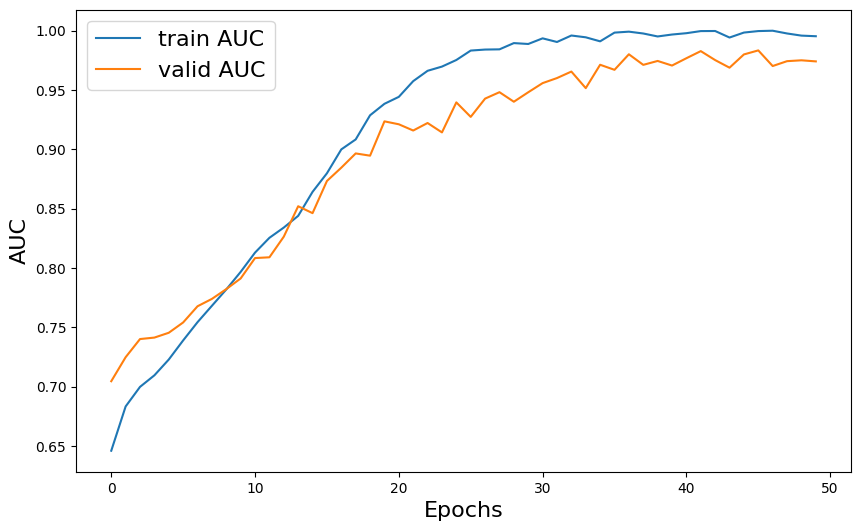

In [7]:
callback = keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)

history = mpnn_transformer.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,
    verbose=2,
    callbacks = [callback]
)

plt.figure(figsize=(10, 6))
plt.plot(history.history["AUC"], label="train AUC")
plt.plot(history.history["val_AUC"], label="valid AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)

## 3. Prediction

Suppose that we want to identify which existing antiviral drugs can be repurposed to target the SARS coronavirus 3C-like Protease. For training the deep learning model, we use the data from past bioassay data such as high throughput screening (HTS) assay on SARS-CoV 3CL Protease, which conserves large portion of the gene with SARS-CoV-2. For repurposing for COVID-19, the deep learning model is trained using this data to rank drug candidates from the antiviral library.

In [8]:
# from https://github.com/dongminjung/DeepPINCS/tree/master/data
antiviral_drug = pd.read_csv("data/antiviral_drug.csv")
SARS_CoV2_3CL_Protease = pd.read_csv("data/SARS_CoV2_3CL_Protease.csv")
new_df = antiviral_drug
new_df["AAseq"] = SARS_CoV2_3CL_Protease.iloc[0].values[0]

In [9]:
test_dataset = preprocess.get_train_valid_dataset(new_df, "smiles", "AAseq", processed_AAseq=preprocess.processed_AAseq, test_size=0)
y_pred = mpnn_transformer.predict(test_dataset)

3/3 [==============================] - 1s 43ms/step


In [10]:
new_df["y_pred"] = y_pred
new_df.sort_values(by='y_pred', ascending=False)[:20]

,drug,smiles,AAseq,y_pred
41,Loviride,CC1=CC(=C(C=C1)C(=O)C)NC(C2=C(C=CC=C2Cl)Cl)C(=O)N,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,1.000000
32,Ganciclovir,C1=NC2=C(N1COC(CO)CO)NC(=NC2=O)N,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,0.999689
69,Tenofovir_disoproxil,CC(C)OC(=O)OCOP(=O)(COC(C)CN1C=NC2=C(N=CN=C21)...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,0.998173
46,Nevirapine,CC1=C2C(=NC=C1)N(C3=C(C=CC=N3)C(=O)N2)C4CC4,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,0.957173
76,Vidarabine,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CO)O)O)N,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,0.821508
74,Valganciclovir,CC(C)C(C(=O)OCC(CO)OCN1C=NC2=C1N=C(NC2=O)N)N,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,0.322716
71,Trifluridine,C1C(C(OC1N2C=C(C(=O)NC2=O)C(F)(F)F)CO)O,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,0.295146
19,Didanosine,C1CC(OC1CO)N2C=NC3=C2N=CNC3=O,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,0.198961
60,Rilpivirine,CC1=CC(=CC(=C1NC2=NC(=NC=C2)NC3=CC=C(C=C3)C#N)...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,0.137753
73,Valacyclovir,CC(C)C(C(=O)OCCOCN1C=NC2=C1N=C(NC2=O)N)N,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,0.079809


Reference

Huang, K \. , Fu, T., Glass, L. M., Zitnik, M., Xiao, C., & Sun, J. (2020). DeepPurpose: A Deep Learning Library for Drug-Target Interaction Prediction. Bioinformatics.

Jung D (2023). DeepPINCS: Protein Interactions and Networks with Compounds based on Sequences using Deep Learning.

akensert (2021). Message-passing neural network (MPNN) for molecular property prediction (https://keras.io/examples/graph/mpnn-molecular-graphs/)

Apoorv Nandan (2020). Text classification with Transformer (https://keras.io/examples/nlp/text_classification_with_transformer/)